In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, RocCurveDisplay, roc_curve
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV


## EDA

In [2]:
df = pd.read_csv("./data/labeled.csv", sep=',')

In [3]:
df.shape

(14412, 2)

In [4]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [5]:
df["toxic"] = df["toxic"].apply(int)

In [6]:
df["toxic"].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [7]:
for c in df[df["toxic"] == 1]["comment"].head(5):
    print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [8]:
for c in df[df["toxic"] == 0]["comment"].head(5):
    print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [9]:
train_df, test_df = train_test_split(df, test_size = 500)
test_df.shape


(500, 2)

In [10]:
test_df["toxic"].value_counts()

0    346
1    154
Name: toxic, dtype: int64

In [11]:
train_df["toxic"].value_counts()

0    9240
1    4672
Name: toxic, dtype: int64

## Text preprocessing

In [12]:
example = df.iloc[1]["comment"]
tokens = word_tokenize(example, language="russian")
tokens_without_punct = [i for i in tokens if i not in string.punctuation]
stop_words = stopwords.words("russian")

tokens_without_punct_and_stopwords = [i for i in tokens_without_punct if i not in stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_punct_and_stopwords]


print(f"Исходный текст: {example}")
print("-----------------")
print(f"Токены: {tokens}")
print("-----------------")
print(f"Токены без пунктуации: {tokens_without_punct}")
print("-----------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_punct_and_stopwords}")
print("-----------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-----------------")

Исходный текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

-----------------
Токены: ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
-----------------
Токены без пунктуации: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
-----------------
Токены без пунктуации и стоп слов: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
-----------------
Токены после стемминга: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']
-----------------


In [13]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [14]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [15]:
features = vectorizer.fit_transform(train_df["comment"])

/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Model training

In [16]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df["toxic"])

LogisticRegression(random_state=0)

In [17]:
model.predict(features[0])

array([0])

In [18]:
train_df["comment"].iloc[0]

'Как по мне, фильм до абсурда перегружен киноштампами жанра, от пафоса тошнит, а из-за катавасии со сценарием слишком много лишних и ненужных для сюжета эпизодов. Тем не менее, показать нам захватывающую историю с отлично поставленным экшеном смогли.\n'

In [19]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))
]
)

In [20]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f7a026c7700>)),
                ('model', LogisticRegression(random_state=0))])

In [21]:
model_pipeline.predict(["Нормальное видео, лайк, репост"])

array([0])

In [22]:
model_pipeline.predict(["Отстой, что за тупые советы"])

array([1])

## Измерим метрики

In [23]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.8727272727272727

In [24]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.6233766233766234

In [25]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

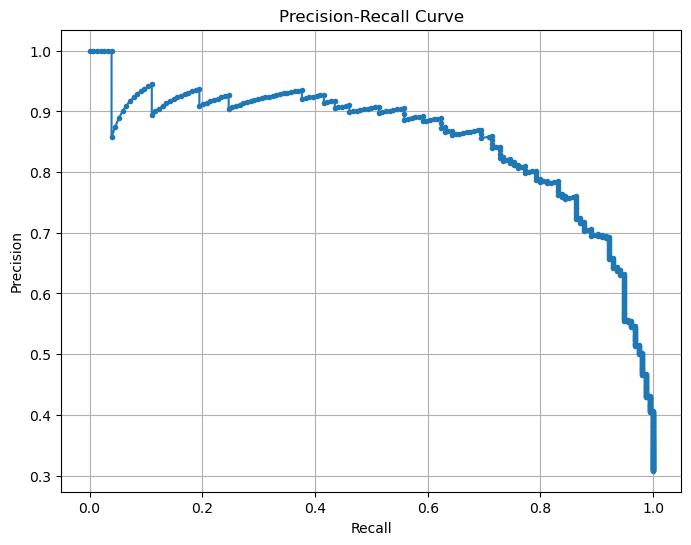

In [26]:
# Построение кривой precision-recall
plt.figure(figsize=(8, 6))
plt.plot(rec, prec, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [27]:
# Найти индексы, где точность больше 0.95
indices_high_precision = np.where(prec > 0.95)[0]
indices_high_precision

array([493, 494, 495, 496, 497, 498, 499])

In [28]:
max_recall_index = indices_high_precision[np.argmax(rec[indices_high_precision])]
threshold_with_max_recall = thresholds[max_recall_index]
max_recall_value = rec[max_recall_index]

print(f"Threshold with precision > 0.95 and maximum recall: {max_recall_index}")
print(f"Maximum recall at this threshold: {max_recall_value}")

Threshold with precision > 0.95 and maximum recall: 493
Maximum recall at this threshold: 0.03896103896103896


In [29]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[414])

0.9047619047619048

In [30]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[414])

0.4935064935064935

## Улучшение модели

Попробуем подобрать коэффициен регуляризации с

In [31]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])

In [32]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.683 total time=   0.2s
[CV 2/3] END .............................C=0.1;, score=0.688 total time=   0.1s
[CV 3/3] END .............................C=0.1;, score=0.689 total time=   0.1s
[CV 1/3] END ...............................C=1;, score=0.834 total time=   0.2s
[CV 2/3] END ...............................C=1;, score=0.838 total time=   0.2s
[CV 3/3] END ...............................C=1;, score=0.840 total time=   0.2s


/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ............................C=10.0;, score=0.861 total time=   0.4s


/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END ............................C=10.0;, score=0.866 total time=   0.3s


/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ............................C=10.0;, score=0.873 total time=   0.4s


/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f7a217d84c0>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [33]:
best_params = grid_pipeline.named_steps['model'].best_params_
best_score = grid_pipeline.named_steps['model'].best_score_

print("Лучшие параметры:", best_params)
print("Наилучшая оценка:", best_score)


Лучшие параметры: {'C': 10.0}
Наилучшая оценка: 0.8665185154599984


In [34]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
]
)
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/amakarshina/opt/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f7a2182c160>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [35]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])

In [36]:
indices_high_precision = np.where(prec_c_10 > 0.95)[0]
indices_high_precision
max_recall_index = indices_high_precision[np.argmax(rec[indices_high_precision])]
threshold_with_max_recall = thresholds_c_10[max_recall_index]
max_recall_value = rec[max_recall_index]

print(f"Threshold with precision > 0.95 and maximum recall: {max_recall_index}")
print(f"Maximum recall at this threshold: {max_recall_value}")

Threshold with precision > 0.95 and maximum recall: 432
Maximum recall at this threshold: 0.4025974025974026


In [39]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[432])

0.9545454545454546

In [40]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[432])

0.4090909090909091